# **Data Cleaning Notebook**

## Objectives

- Evaluate missing data
- Clean data

## Inputs

- outputs/datasets/collection/house_prices_records.csv

## Outputs

- Cleaned Train and Test sets

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/PP5-Heritage-Housing-Issue/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/PP5-Heritage-Housing-Issue'

# Load Data

In [4]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/house_prices_records.csv")
    )
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

# Data Exploration

In [5]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [6]:
from pandas_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

/tmp/ipykernel_6599/3398083222.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

def heatmap_corr(df,threshold, figsize=(20,12), font_annot = 8):
  if len(df.columns) > 1:
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df) < threshold] = True

    fig, axes = plt.subplots(figsize=figsize)
    sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                linewidth=0.5
                     )
    axes.set_yticklabels(df.columns, rotation = 0)
    plt.ylim(len(df.columns),0)
    plt.show()


def heatmap_pps(df,threshold, figsize=(20,12), font_annot = 8):
    if len(df.columns) > 1:

      mask = np.zeros_like(df, dtype=np.bool)
      mask[abs(df) < threshold] = True

      fig, ax = plt.subplots(figsize=figsize)
      ax = sns.heatmap(df, annot=True, xticklabels=True,yticklabels=True,
                       mask=mask,cmap='rocket_r', annot_kws={"size": font_annot},
                       linewidth=0.05,linecolor='grey')
      
      plt.ylim(len(df.columns),0)
      plt.show()



def CalculateCorrAndPPS(df):
  df_corr_spearman = df.corr(method="spearman")
  df_corr_pearson = df.corr(method="pearson")

  pps_matrix_raw = pps.matrix(df)
  pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

  pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
  print("PPS threshold - check PPS score IQR to decide the threshold for the heatmap \n")
  print(pps_score_stats.round(3))

  return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix,CorrThreshold,PPS_Threshold,
                      figsize=(20,12), font_annot=8 ):

  print("\n")
  print("* Analyze how the target variable for your ML models are correlated with other variables (features and target)")
  print("* Analyze multi colinearity, that is, how the features are correlated among themselves")

  print("\n")
  print("*** Heatmap: Spearman Correlation ***")
  print("It evaluates monotonic relationship \n")
  heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Pearson Correlation ***")
  print("It evaluates the linear relationship between two continuous variables \n")
  heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Predictive power Score (PPS) ***")
  print(f"PPS detects linear or non-linear relationships between two columns.\n"
        f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
  heatmap_pps(df=pps_matrix,threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

In [8]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspa

PPS threshold - check PPS score IQR to decide the threshold for the heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702




* Analyze how the target variable for your ML models are correlated with other variables (features and target)
* Analyze multi colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



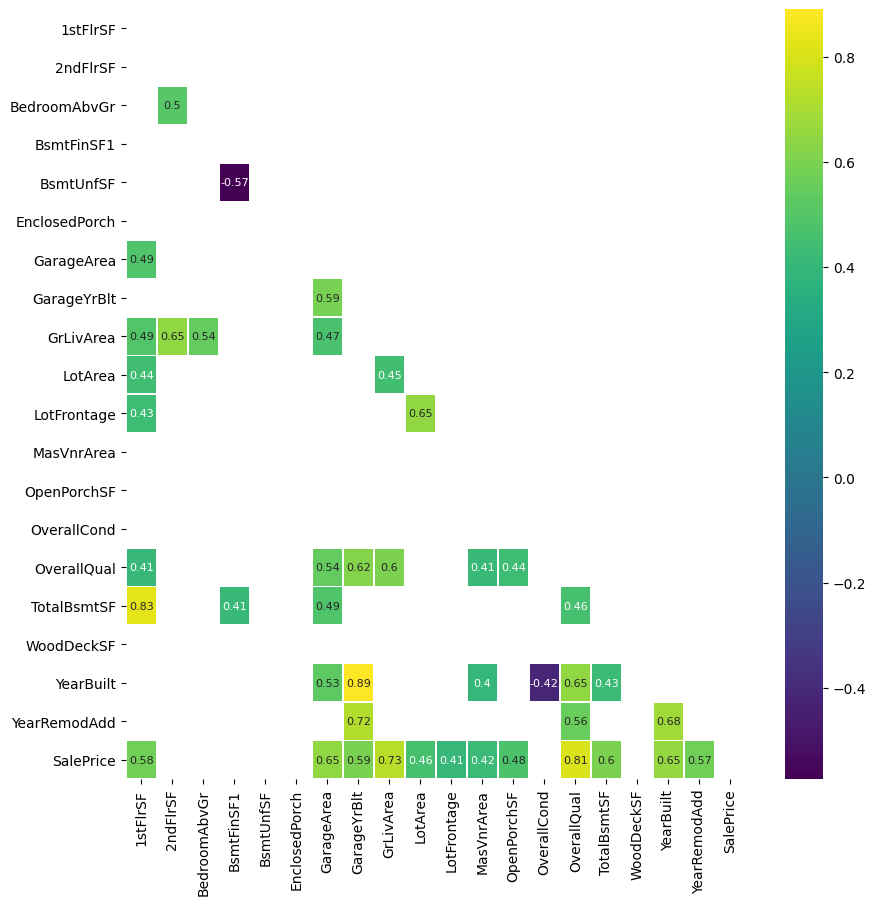



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



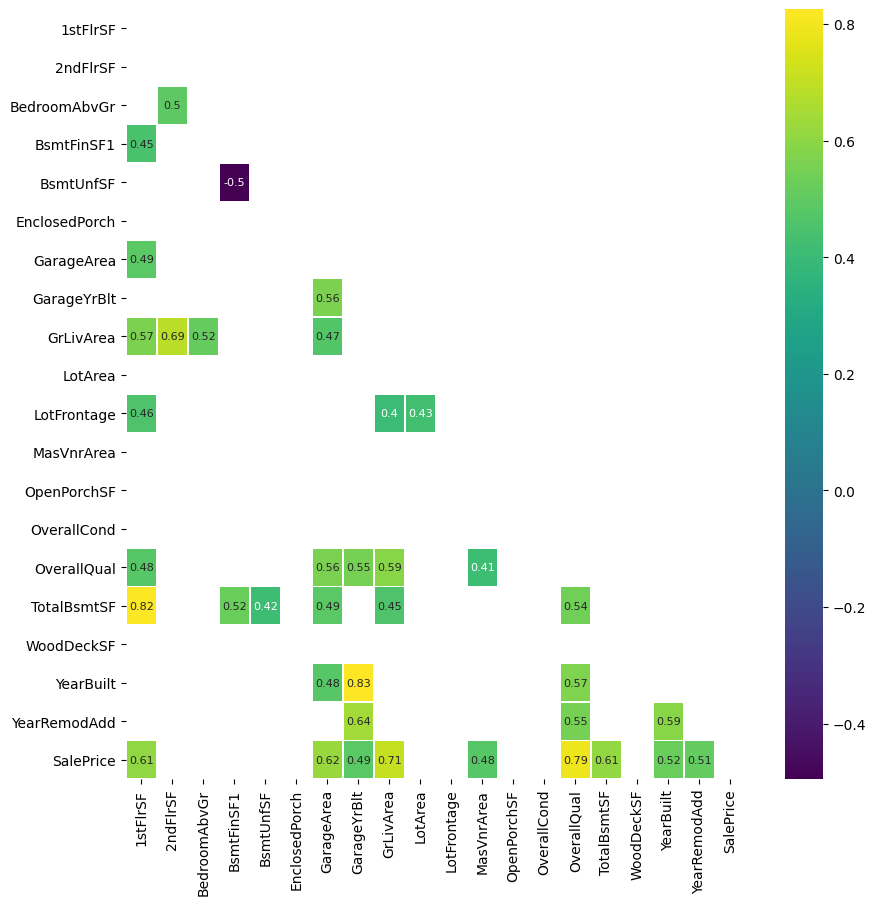



*** Heatmap: Predictive power Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



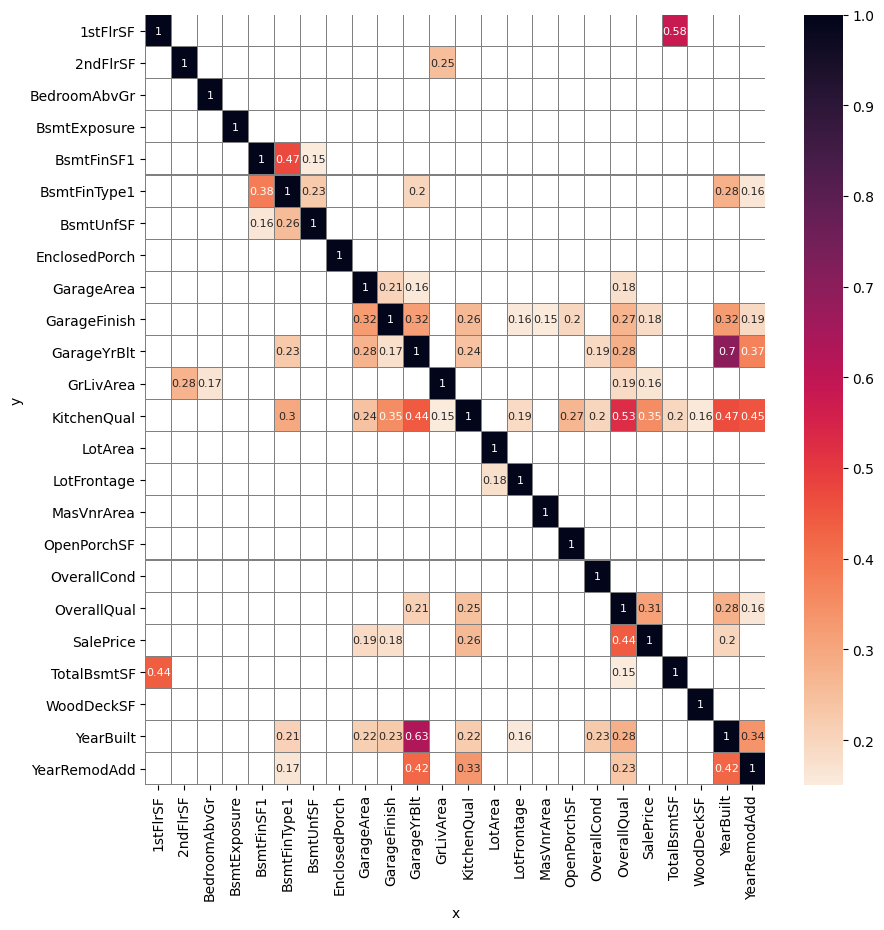

In [9]:
DisplayCorrAndPPS(df_corr_pearson=df_corr_pearson,
                  df_corr_spearman=df_corr_spearman, 
                  pps_matrix=pps_matrix,
                  CorrThreshold=0.4, PPS_Threshold=0.15,
                  figsize=(10,10), font_annot=8)

In [10]:
def EvaluateMissingData(df):
  missing_data_absolute = df.isnull().sum()
  missing_data_percentage = round(missing_data_absolute/len(df)*100 , 2)
  df_missing_data = (pd.DataFrame(
                          data= {"RowsWithMissingData": missing_data_absolute,
                                 "PercentageOfDataset": missing_data_percentage,
                                 "DataType":df.dtypes}
                                  )
                    .sort_values(by=['PercentageOfDataset'],ascending=False)
                    .query("PercentageOfDataset > 0")
                    )

  return df_missing_data

In [11]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


### Copy

We create a copy first and apply the changes individually

In [12]:
df_cleaned = df.copy()
df_cleaned

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,953,694.0,3.0,No,0,Unf,953,NaN,460,RFn,...,62.0,0.0,40,5,6,953,0.0,1999,2000,175000
1456,2073,0.0,NaN,No,790,ALQ,589,NaN,500,Unf,...,85.0,119.0,0,6,6,1542,NaN,1978,1988,210000
1457,1188,1152.0,4.0,No,275,GLQ,877,NaN,252,RFn,...,66.0,0.0,60,9,7,1152,NaN,1941,2006,266500
1458,1078,0.0,2.0,Mn,49,NaN,0,112.0,240,Unf,...,68.0,0.0,0,6,5,1078,NaN,1950,1996,142125


## Analysis

In order of appearance:

- EnclosedPorch - 90.68% missing data:
We drop this

- WooDeckSF - 89.38% missing data:
We drop this

- LotFrontage - 17.74% missing data:
    - Moderate correlation to Sale Price, no predicting power
    - Missing data cannot be 0, as logically as it represents linear feet of street connected to the property.
    - Significant right skew
    - Might use the median to fill the missing data
    - median = 69
    - mean = 70

- GarageFinish - 11.10% missing data:
    - Categorical
    - 4 values: unf, rfn, fin, none
    - check if null and none have no garage area, if no garage area we can impute none, otherwise unf

- BsmtFinType1 - 7.81% missing data:
    - 7 categorical text values
    - like with garage, check missing values if they have basement area

- BedroomAbvGr - 6.78% missing data:
    - further analysis required
    - median = 3
    - mean = 2.9

- 2ndFlrSF - 5.89% missing data:
    - If no second floor, value can be set to 0
    - Needs comparing with other properties

- GarageYrBlt - 5.55% missing data:
    - very high correlation with year built
    - missing data could be built year data, logically makes sense
    - if garagefinish, area and yearbuilt is none property could have no garage

- MasVnrArea - 0.55% missing data:
    - lack of value could mean no masonry veneer area

## Data Cleaning

### EnclosedPorch and WooDeckSF

Significant amount of data missing. We drop these variables.

In [13]:
df_cleaned = df_cleaned.drop(columns=['EnclosedPorch', 'WoodDeckSF'])

We check that the variables have been correcty dropped

In [14]:
for column in df_cleaned.columns:
    print(column)

1stFlrSF
2ndFlrSF
BedroomAbvGr
BsmtExposure
BsmtFinSF1
BsmtFinType1
BsmtUnfSF
GarageArea
GarageFinish
GarageYrBlt
GrLivArea
KitchenQual
LotArea
LotFrontage
MasVnrArea
OpenPorchSF
OverallCond
OverallQual
TotalBsmtSF
YearBuilt
YearRemodAdd
SalePrice


### LotFrontage

### GarageFinish

### BsmtFinType1

Check

In [ ]:
missing_bsmtfin_type1 = df_cleaned[df_cleaned['BsmtFinType1'].isnull()]
print(f"Amount of rows with missing data: {len(missing_bsmtfin_type1)}")
missing_bsmtfin_type1[['BsmtFinType1', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1']]

Check for BsmtFinType1 missing values and TotalBsmtSF value of 0.
These values will have no basement and thus BsmtFinType1 will be none.
The rows below have no finished, unfinished and total basement, furthermore also no BsmtExposure, we can safely say there is no basement and impute None.

In [ ]:
df_basement_none = df_cleaned[(df['BsmtFinType1'].isnull()) & (df['TotalBsmtSF'] == 0)]
print(f"Amount of rows with missing data: {len(df_basement_none)}")
df_basement_none[['BsmtFinType1', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1', 'BsmtExposure']]

Let us apply the changes to the copy

In [ ]:
df_cleaned.loc[(df_cleaned['TotalBsmtSF'] == 0) & (df_cleaned['BsmtFinType1'].isnull()), 'BsmtFinType1'] = 'None'

Check

In [ ]:
missing_bsmtfin_type1 = df_cleaned[df_cleaned['BsmtFinType1'].isnull()]
missing_bsmtfin_type1[['BsmtFinType1', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1']]

The values belows indicate that the variable BsmtUnfSF has 0 square feet unfinished, and since the TotalBsmtSF is greater than 0, it suggests the basement is finished but no category has been assigned.
As we cannot deduce if it is a rec room/living quarter and the quality, we should create a new category: "Finished".

In [ ]:
df_basement_finished = df_cleaned[(df_cleaned['BsmtFinType1'].isnull()) & (df['BsmtUnfSF'] == 0)]
print(f"Amount of rows with missing data: {len(df_basement_finished)}")
df_basement_finished[['BsmtFinType1', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1']]

Let us apply the changes to the copy

In [ ]:
df_cleaned.loc[(df_cleaned['BsmtFinType1'].isnull()) & (df['BsmtUnfSF'] == 0), 'BsmtFinType1'] = 'Fin'

Check

In [ ]:
missing_bsmtfin_type1 = df_cleaned[df_cleaned['BsmtFinType1'].isnull()]
print(f"Amount of rows with missing data: {len(missing_bsmtfin_type1)}")
missing_bsmtfin_type1[['BsmtFinType1', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1']]

The values below have a value of unfinished SF basement higher than 0. We can impute "Unfinished"

In [ ]:
df_basement_unfinished = df_cleaned[(df_cleaned['BsmtFinType1'].isnull()) & (df['BsmtUnfSF'] > 0)]
print(f"Amount of rows with missing data: {len(df_basement_unfinished)}")
df_basement_unfinished[['BsmtFinType1', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1']]

In [ ]:
df_cleaned.loc[(df_cleaned['BsmtFinType1'].isnull()) & (df['BsmtUnfSF'] > 0), 'BsmtFinType1'] = 'Unf'

Check

In [ ]:
missing_bsmtfin_type1 = df_cleaned[df_cleaned['BsmtFinType1'].isnull()]
print(f"Amount of rows with missing data: {len(missing_bsmtfin_type1)}")
missing_bsmtfin_type1[['BsmtFinType1', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1']]

### BedroomAbvGr

### 2ndFlrSF

### GarageYrBlt

### MasVnrArea

---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
